Import libs:

In [1]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from IPython.core.display import HTML
from IPython.display import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import numpy as np  
import pandas as pd
from tqdm import tqdm
import networkx as nx
import collections
import operator

import pymorphy2
import pymystem3
import random
import string

import winsound
import nltk
import re

Remove warnings:

In [2]:
import warnings
warnings.filterwarnings('ignore')

Parameters:

In [3]:
flag = 'left' 
imp_POS = ['NOUN']

CFDs:

In [4]:
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return str(s) 

def normalizemorph(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in imp_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
    return words

def getMostFrequentWordsFiltered(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    
    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in imp_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
            
    text = ' '.join(words)
    counter = CountVectorizer(ngram_range=(1,2), token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')
    res = counter.fit_transform([text])
    frq = sorted([(i, int(res[0][0,i])) for i in range(res[0].shape[1])], key = lambda x: x[1], reverse = True)[:3]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    
    return vocab

def getMostFrequentWords(text):
    counter = CountVectorizer(ngram_range=(1,2), token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')

    res = counter.fit_transform([text])
    frq = sorted([(i, int(res[0][0,i])) for i in range(res[0].shape[1])], key=lambda x: x[1],reverse=True)[:3]

    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] for i, f in frq], vocab

def normalizePymorphy2(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        words.append(pv[0].normal_form)
    return words

def remove_brackets(item):
    result = re.search(r'\([^)]*\)', item)
    p_item = item

    if result and re.search(',', str(result.group())):
        p_item = re.sub(r'\([^)]*\)', '', item)
        
    return p_item

Settings:

In [5]:
tqdm.pandas()
mystem = pymystem3.Mystem()
morph = pymorphy2.MorphAnalyzer()

Get data:

In [6]:
df = pd.read_csv('data/tnps.csv')[['fname', 'txt']]
df = df.sample(frac=0.1)

df = df.astype(str)
df = df[df['fname'].str.contains(flag)]
df.dropna(how='any', axis=0, inplace=True)
df = df[['txt']]

print('Number of messages:', len(df))

Number of messages: 1001


Define dimension:

In [7]:
txt_collection = ' '.join(df['txt'].tolist())
tok_num = round(len(txt_collection.split())/(10**6), 2)
print('Number of tokens without voc filter:', tok_num, 'mln')

Number of tokens without voc filter: 0.15 mln


Word distribution:

[]

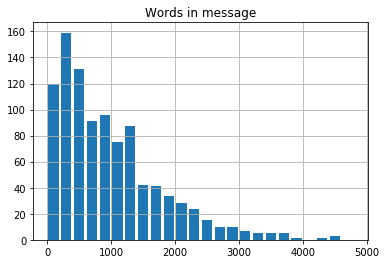

In [8]:
lens = df['txt'].str.len()
lens.hist(bins = np.arange(0,5000,200), rwidth=0.8)
plt.title('Words in message')
plt.plot()

#### Dimension reduction

Alphabet, stopwords, cases:

In [9]:
df['txt'] = df.txt.str.replace(r'[^а-яА-я ]\s?', r'', regex=True)
df['txt'] = df['txt'].astype(str)

space_remove = lambda x: re.sub(' +', ' ', x)
lower_case = lambda x: x.strip().lower() 
df['txt'] = df['txt'].apply(space_remove).apply(lower_case)

stop = list(nltk.corpus.stopwords.words('russian'))
df['txt'] = df['txt'].apply(lambda x: [item for item in x.split() if item not in stop])
df['txt'] = df['txt'].apply(lambda x: ' '.join(x))

Write stopwords to file:

In [10]:
with open('data/stop.txt','w') as f:
    f.write('\n'.join(nltk.corpus.stopwords.words('russian')))

print('Число стоп слов:', len(nltk.corpus.stopwords.words('russian')))

Число стоп слов: 151


Filter by morphological analyzer:

In [11]:
morph = pymorphy2.MorphAnalyzer()
leave_voc = (lambda x: ' '.join([item for item in x.split() if morph.parse(item)[0].tag.POS is not None]))
df['txt'] = df['txt'].progress_apply(leave_voc)
winsound.Beep(440, 1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:15<00:00, 63.08it/s]


Convert to standard form:

In [12]:
standart_it = (lambda x: ' '.join(normalizemorph(x)))
df['txt'] = df['txt'].progress_apply(standart_it)
winsound.Beep(440, 1000)

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [00:16<00:00, 62.35it/s]


Stemming:

In [13]:
stem_it = (lambda x: ''.join(mystem.lemmatize(x)))
df['txt'] = df['txt'].progress_apply(stem_it)

100%|██████████████████████████████████████████████████████████████████████████████| 1001/1001 [18:02<00:00,  1.08s/it]


Define number of tokens:

In [14]:
txt_collection = ' '.join(df['txt'].tolist())
tok_num = round(len(txt_collection.split())/(10**6), 2)
print('Number of tokens without voc filter:', tok_num, 'mln')

Number of tokens without voc filter: 0.05 mln


End of section:

In [15]:
winsound.Beep(440, 1000)

#### Frequency analysis

Create WordCloud - TOP200 of normalized CountVectorizer:

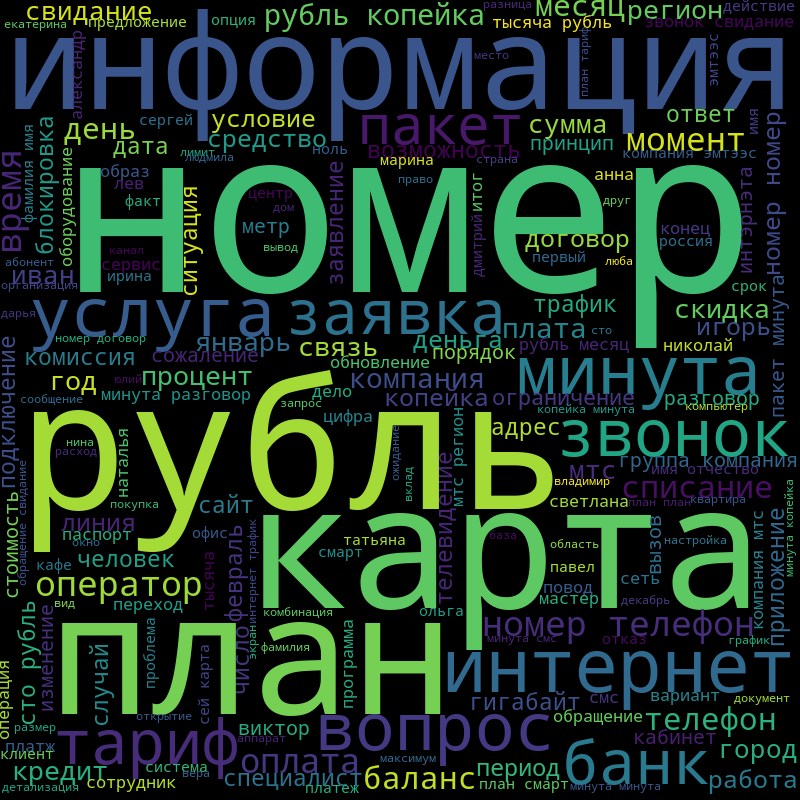

In [16]:
wordcloud = WordCloud(width=800, height=800, margin=0).generate(txt_collection)
wordcloud.to_file('data/cloud.png')
Image(filename = 'data/cloud.png', width=400, height=400)

CountVectorizer with normal form:

In [17]:
txt_collection_sample = ' '.join(df['txt'].sample(frac=1).tolist())
freq_voc = getMostFrequentWordsFiltered(txt_collection_sample)

df_count = pd.DataFrame(list(freq_voc.items()), columns = ['token','counts']) 
df_count = df_count.sort_values(by=['counts'], ascending=False)
df_count.set_index('counts', inplace=True)

df_count.to_excel('data/counts.xlsx', sheet_name='Data', index = False)
df_count.head()

,token
counts,
1805,номер
1342,рубль
923,минута
850,план
674,интернет


CountVectorizer by message:

In [18]:
df['txt'].replace('', np.nan, inplace=True)
df.dropna(subset=['txt'], inplace=True)
freqwords, vocabs = [], []

for i in tqdm(range(df.txt.shape[0])):
    fw, v = getMostFrequentWords(df.txt.iloc[i])
    freqwords.append(fw)
    vocabs.append(v)
    
df['Vocabular'] = vocabs
df['Freq Words'] = freqwords
df.to_excel('data/counts_message.xlsx', sheet_name='Data', index = False)

100%|████████████████████████████████████████████████████████████████████████████████| 973/973 [00:09<00:00, 99.95it/s]


TF-IDF:

In [19]:
tfCounter = TfidfVectorizer(ngram_range=(1,2), token_pattern=r'[А-Яа-яЁё]+\-[А-Яа-яЁё]+|[А-Яа-яЁё]+')
tfres = tfCounter.fit_transform([' '.join(normalizePymorphy2(n)) for n in tqdm(df.txt)])

freqwords = []
for i in tqdm(range(df.txt.shape[0])):

    tfs = [(k,tfres[i][0, tfCounter.vocabulary_.get(k)]) for k in df.Vocabular.iloc[i] 
           if k in tfCounter.vocabulary_.keys()]
    fw = [w for w, f in sorted(tfs, key = lambda x: x[1], reverse = True)[:5]]
    freqwords.append(fw)
    
df['Freq Words TFIDF'] = freqwords
df.to_excel('data/tf_idf.xlsx', sheet_name='Data', index = False)

100%|███████████████████████████████████████████████████████████████████████████████| 973/973 [00:06<00:00, 142.99it/s]


Create Corpora list:

In [20]:
df_corpora = pd.read_excel('data/corpora.xlsx')

df_corpora['tokens'] = df_corpora['tokens'].apply(lambda x: re.sub(r'\([^)]*\)', '', x))
df_corpora['tokens'] = df_corpora['tokens'].str.replace(r'[^а-яА-я ]\s?', r'', regex=True)
df_corpora['tokens'] = df_corpora['tokens'].apply(space_remove).apply(lower_case)
corpora = df_corpora['tokens'].tolist()

print('Words in Corpora mini:', len(corpora))

Words in Corpora mini: 9197


Percentage of recognized words:

In [21]:
print('Recognized percentage:', int(100*len(set(df['txt'].tolist()))/len(corpora)), '%')

Recognized percentage: 10 %


#### Graph

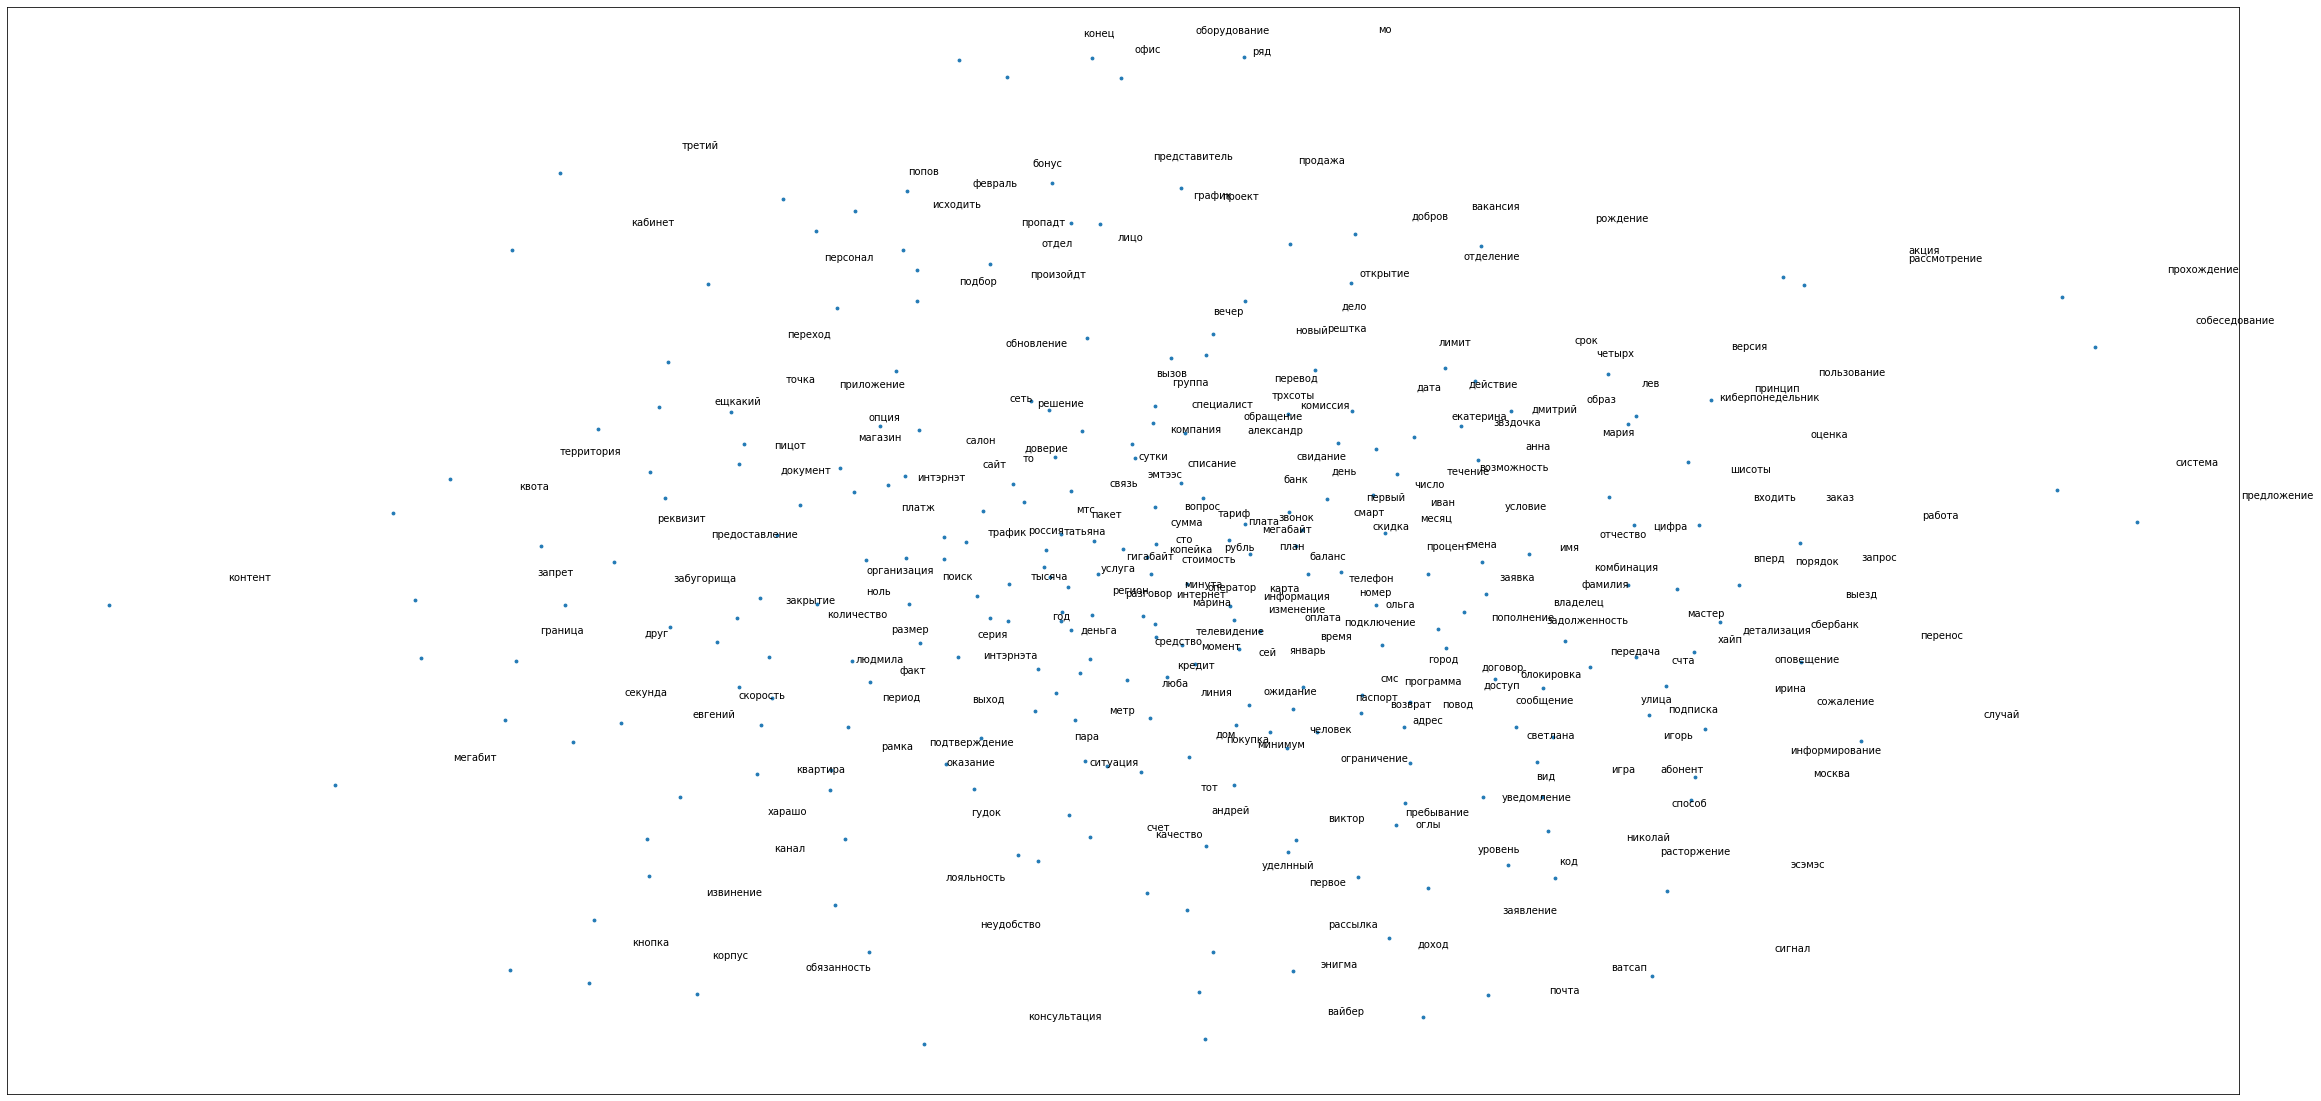

In [22]:
top_n = 900

bgrms = list(nltk.bigrams(nltk.word_tokenize(txt_collection_sample)))
bigram_counts = collections.Counter(bgrms)
bigram_df = pd.DataFrame(bigram_counts.most_common(top_n), columns=['bigram', 'count'])

d = bigram_df.set_index('bigram').T.to_dict('records')
G = nx.Graph()

for k, v in d[0].items():
    G.add_edge(k[0], k[1], weight=(v * 10))

G.add_node('тариф', weight=100)
fig, ax = plt.subplots(figsize=(40, 20))
pos = nx.spring_layout(G, k=1)
nx.draw_networkx(G, pos, font_size=8, width=0, node_size=8, with_labels = False, ax=ax)

for key, value in pos.items():
    x, y = value[0]+.135, value[1]+.045
    ax.text(x, y, s=key, horizontalalignment='center', fontsize=10)

plt.savefig('data/graph.png')
plt.show()